In [13]:
import os
import pandas as pd
import pandasai as pai
from pandasai_litellm.litellm import LiteLLM
import sqlite3
import seaborn as sns
import matplotlib.pyplot as plt

llm = LiteLLM(model="gpt‑3.5‑turbo", api_key=os.getenv("OPENAI_API_KEY"))
pai.config.set({"llm": llm})

df = pd.read_csv("swiggy.csv")
print(df.head())
print(df.info())


# Create in-memory SQLite DB
conn = sqlite3.connect(":memory:")

# Store df into SQL
df.to_sql("funding", conn, index=False, if_exists="replace")

    ID         Area       City         Restaurant  Price  Avg ratings  \
0  211  Koramangala  Bangalore        Tandoor Hut  300.0          4.4   
1  221  Koramangala  Bangalore      Tunday Kababi  300.0          4.1   
2  246    Jogupalya  Bangalore            Kim Lee  650.0          4.4   
3  248  Indiranagar  Bangalore  New Punjabi Hotel  250.0          3.9   
4  249  Indiranagar  Bangalore                Nh8  350.0          4.0   

   Total ratings                                          Food type  \
0            100          Biryani,Chinese,North Indian,South Indian   
1            100                                   Mughlai,Lucknowi   
2            100                                            Chinese   
3            500               North Indian,Punjabi,Tandoor,Chinese   
4             50  Rajasthani,Gujarati,North Indian,Snacks,Desser...   

        Address  Delivery time  
0     5Th Block             59  
1     5Th Block             56  
2   Double Road             50  
3 

8680

In [3]:
# Count Restaurants

restaurant_count = df['Restaurant'].nunique()
print(f"Total unique restaurants: {restaurant_count}")

Total unique restaurants: 7865


In [4]:
# Find Maximum Price

max_price = df['Price'].max()
print(f"Maximum restaurant price: ₹{max_price}")

Maximum restaurant price: ₹2500.0


In [6]:
# Average Ratings

average_rating = df['Avg ratings'].mean()
print(f"Average rating across all restaurants: {average_rating:.2f}")

Average rating across all restaurants: 3.66


In [7]:
# Total Ratings

total_ratings = df['Total ratings'].sum()
print(f"Total number of ratings: {total_ratings}")

Total number of ratings: 1359590


In [8]:
# Food Type Count

food_types = df['Food type'].dropna().str.split(',\s*').explode().str.strip().nunique()
print(f"Number of unique food types: {food_types}")

Number of unique food types: 600


In [9]:
# City Analysis

top_cities = df['City'].value_counts().head(3)
print("Top 3 cities with most restaurants:")
print(top_cities)

Top 3 cities with most restaurants:
City
Kolkata    1346
Mumbai     1277
Chennai    1106
Name: count, dtype: int64


In [11]:
# Price Comparison by Food Type

price_by_food_type = (
    df.dropna(subset=["Food type", "Price"])
    .assign(food_type=df["Food type"].str.split(',\s*'))
    .explode("Food type")
    .groupby("Food type")["Price"]
    .mean()
    .sort_values(ascending=False)
)

print(price_by_food_type)

Food type
Japanese,Korean,Barbecue                                      2500.0
North Indian,Mughlai,Biryani,Grill,Seafood,Kebabs,Desserts    2500.0
Asian,Continental                                             2000.0
Healthy Food,Salads,Pizzas                                    1900.0
Goan,Portuguese                                               1800.0
                                                               ...  
Chaat  Fast Food                                                 2.0
Indian  South Indian  Chinese  Arabian                           2.0
South Indian,Indian,Desserts                                     1.0
Italian  Continental                                             1.0
Continental,Chinese,Italian,Mexican                              0.0
Name: Price, Length: 3734, dtype: float64


C:\Users\Kinjal\AppData\Local\Temp\ipykernel_17468\3300275485.py:9: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


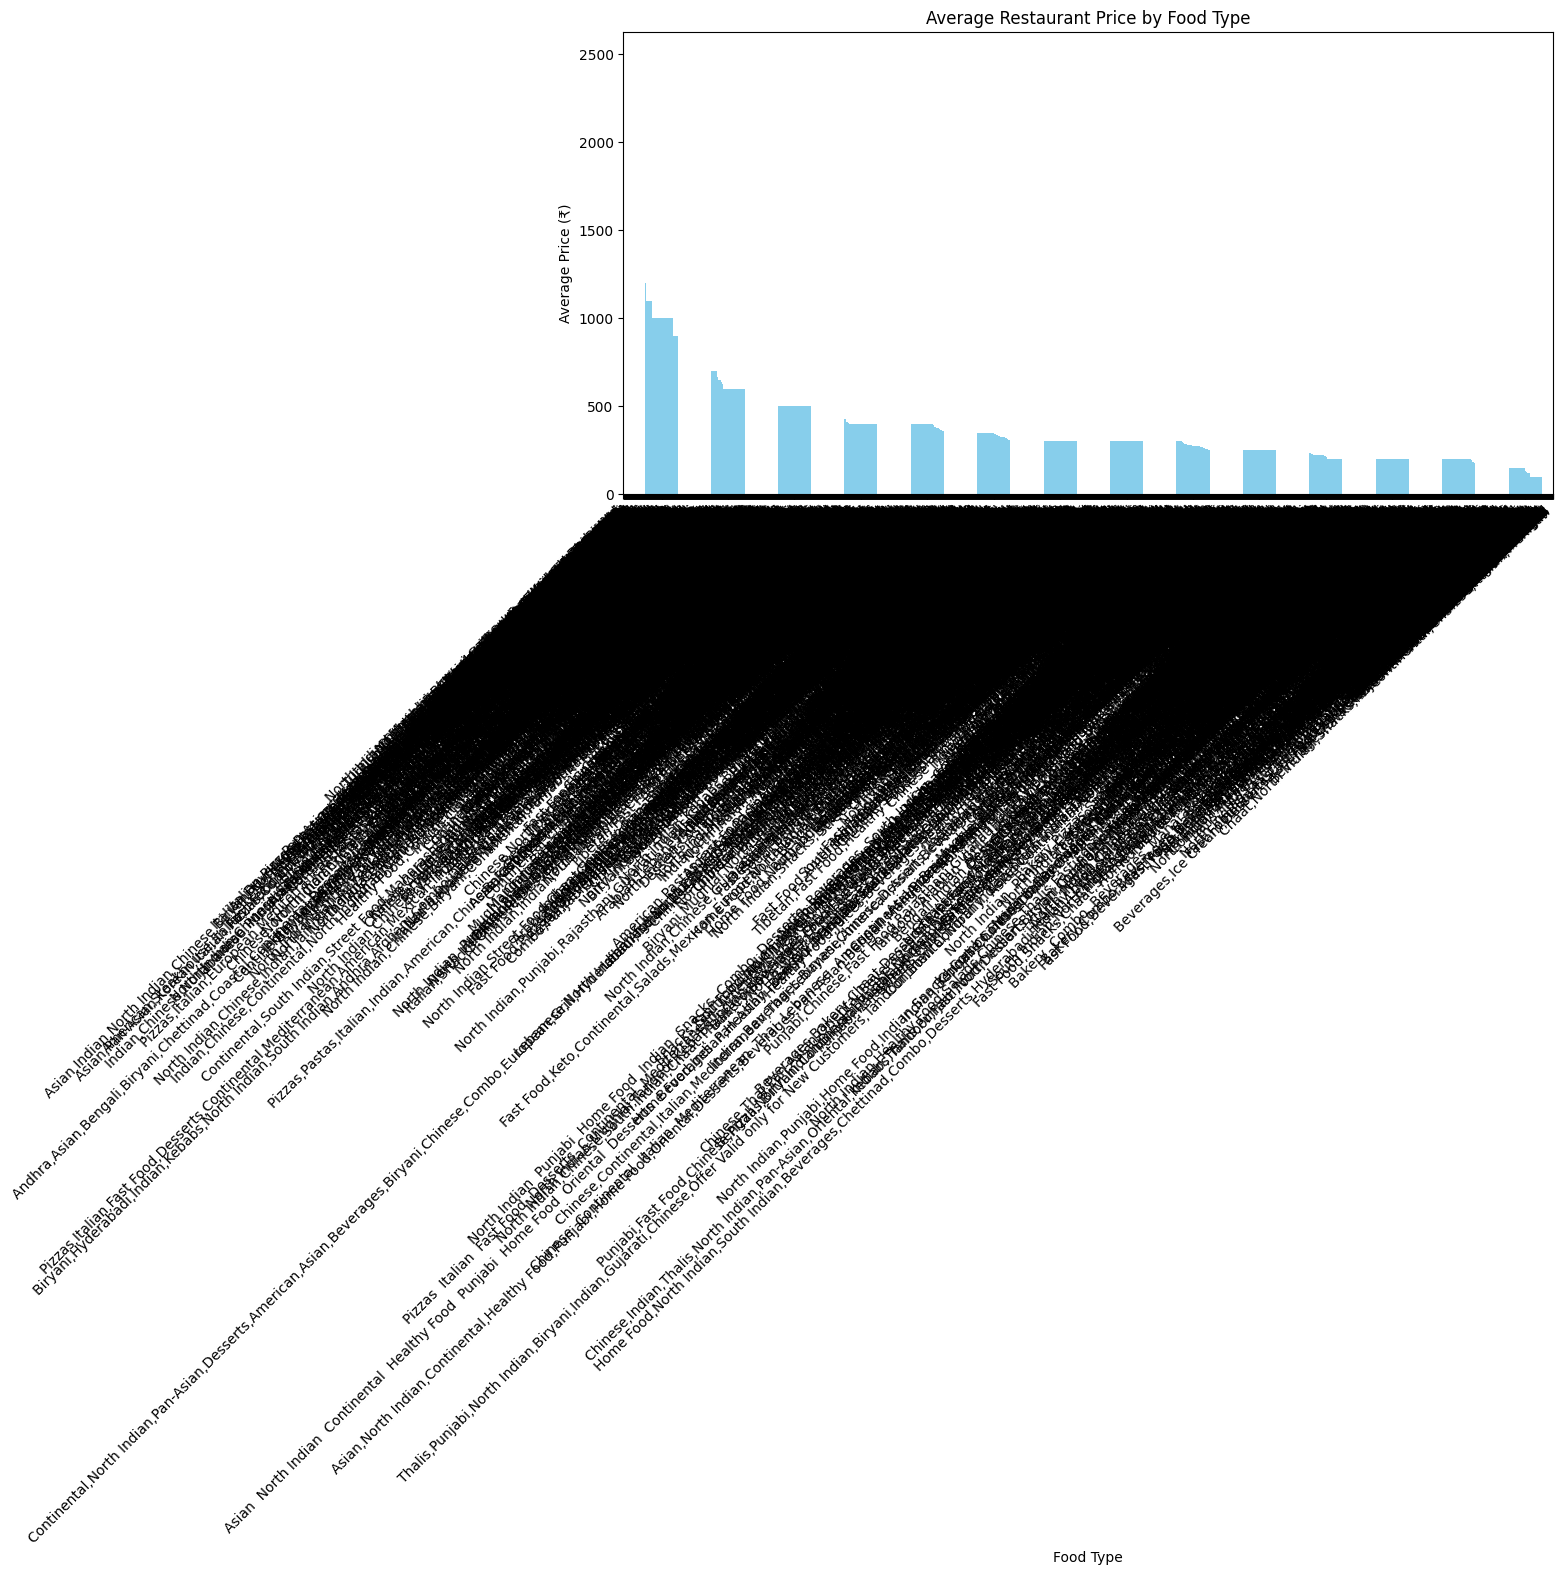

In [14]:
# Bar Chart of Average Price by Food Type

plt.figure(figsize=(12, 6))
price_by_food_type.plot(kind='bar', color='skyblue')
plt.title('Average Restaurant Price by Food Type')
plt.ylabel('Average Price (₹)')
plt.xlabel('Food Type')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


c:\Users\Kinjal\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


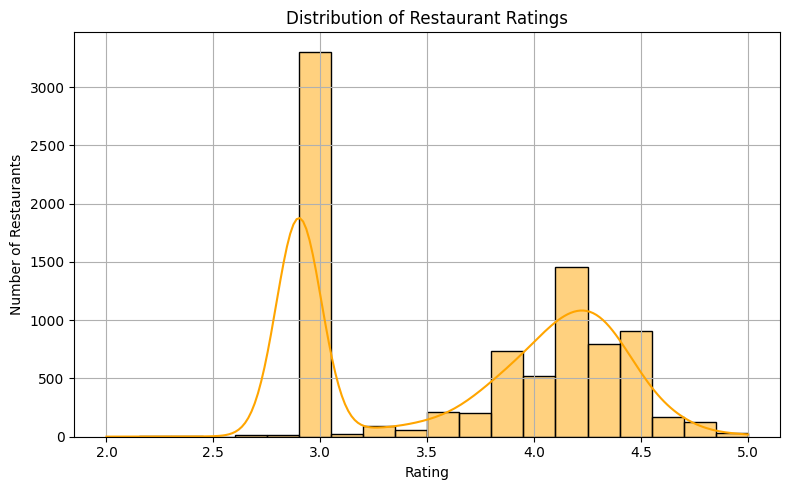

In [16]:
# Rating Distribution Histogram

plt.figure(figsize=(8, 5))
sns.histplot(df['Avg ratings'].dropna(), bins=20, kde=True, color='orange')
plt.title('Distribution of Restaurant Ratings')
plt.xlabel('Rating')
plt.ylabel('Number of Restaurants')
plt.grid(True)
plt.tight_layout()
plt.show()


In [17]:
#  Delivery Time Analysis for Highly Rated Restaurants

highly_rated = df[(df['Avg ratings'] > 4) & df['Delivery time'].notna()]

avg_delivery_time = highly_rated['Delivery time'].mean()
print(f"Average delivery time for restaurants rated above 4: {avg_delivery_time:.2f} mins")

Average delivery time for restaurants rated above 4: 51.99 mins


In [18]:
# Top Rated Restaurants

top_rated = (
    df[['Restaurant', 'Food type', 'Avg ratings']]
    .dropna(subset=['Avg ratings'])
    .sort_values(by='Avg ratings', ascending=False)
    .drop_duplicates(subset=['Restaurant'])
    .head(5)
)

print("Top 5 rated restaurants:")
print(top_rated.to_string(index=False))

Top 5 rated restaurants:
                          Restaurant                      Food type  Avg ratings
                  The Asian Pavilion                 Asian  Chinese          5.0
             Diamond Market Pizza Jp                        Italian          5.0
                   The Liege Waffles               Desserts  Bakery          5.0
              Keventers Ice Creamery             Ice Cream,Desserts          5.0
Splurge - Thickshakes And Milkshakes Desserts  Ice Cream  Beverages          5.0


Correlation coefficient between price and rating: 0.11


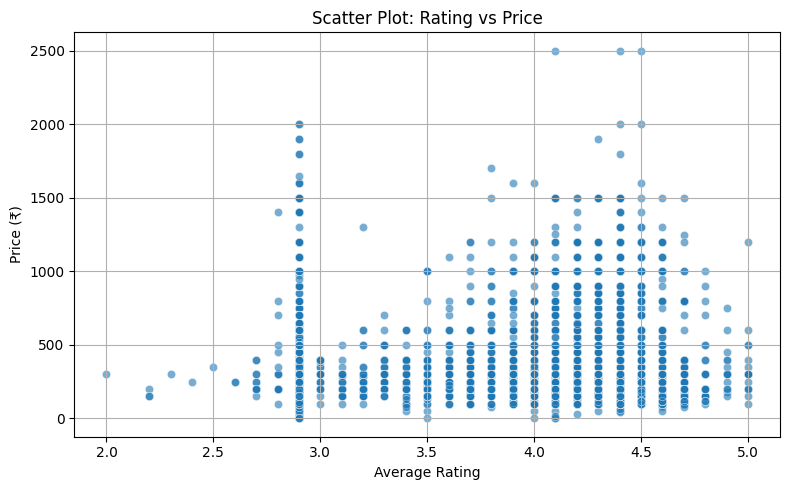

In [19]:
# Correlation Between Price and Rating

# Drop NaNs
filtered = df[['Price', 'Avg ratings']].dropna()

# Correlation coefficient
correlation = filtered['Price'].corr(filtered['Avg ratings'])
print(f"Correlation coefficient between price and rating: {correlation:.2f}")

# Scatter plot
plt.figure(figsize=(8, 5))
sns.scatterplot(data=filtered, x='Avg ratings', y='Price', alpha=0.6)
plt.title("Scatter Plot: Rating vs Price")
plt.xlabel("Average Rating")
plt.ylabel("Price (₹)")
plt.grid(True)
plt.tight_layout()
plt.show()


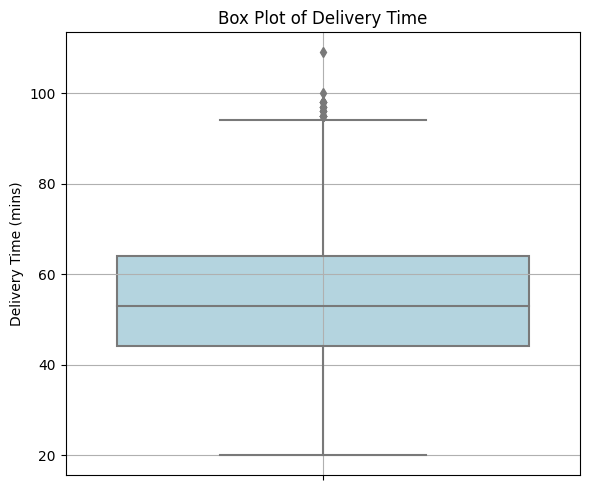

Number of delivery time outliers: 22


In [20]:
# Delivery Time Outliers Using Box Plot

plt.figure(figsize=(6, 5))
sns.boxplot(y=df['Delivery time'], color='lightblue')
plt.title("Box Plot of Delivery Time")
plt.ylabel("Delivery Time (mins)")
plt.grid(True)
plt.tight_layout()
plt.show()

# IQR Outlier Detection
q1 = df['Delivery time'].quantile(0.25)
q3 = df['Delivery time'].quantile(0.75)
iqr = q3 - q1
lower = q1 - 1.5 * iqr
upper = q3 + 1.5 * iqr

outliers = df[(df['Delivery time'] < lower) | (df['Delivery time'] > upper)]
print(f"Number of delivery time outliers: {len(outliers)}")


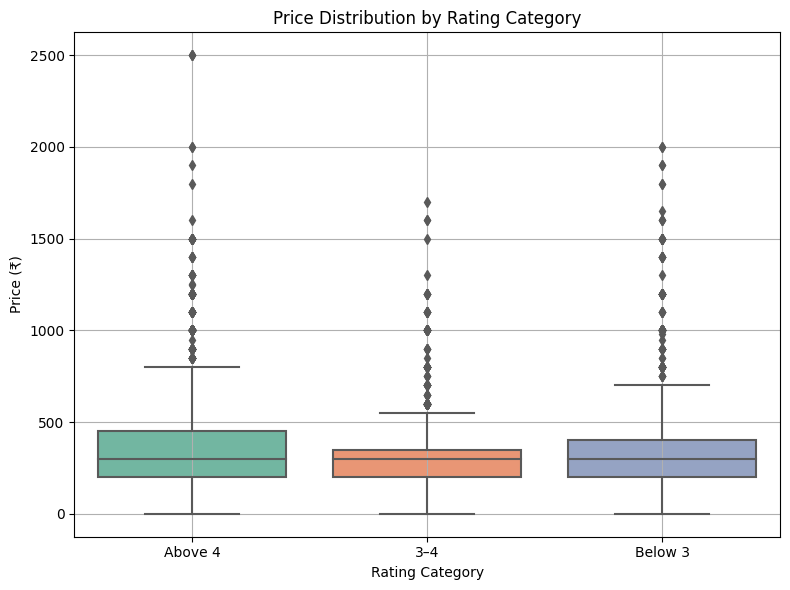

In [22]:
# Box Plot of Price by Rating Category

# Categorize ratings
def categorize_rating(r):
    if r < 3:
        return 'Below 3'
    elif 3 <= r <= 4:
        return '3–4'
    else:
        return 'Above 4'

df['rating_category'] = df['Avg ratings'].apply(categorize_rating)

plt.figure(figsize=(8, 6))
sns.boxplot(data=df, x='rating_category', y='Price', palette='Set2')
plt.title("Price Distribution by Rating Category")
plt.xlabel("Rating Category")
plt.ylabel("Price (₹)")
plt.grid(True)
plt.tight_layout()
plt.show()


                Price  Avg ratings
City                              
Mumbai     393.794832     3.599374
Bangalore  382.524313     3.762896
Kolkata    362.294205     3.698811
Chennai    356.247740     3.776311
Pune       353.763303     3.550183


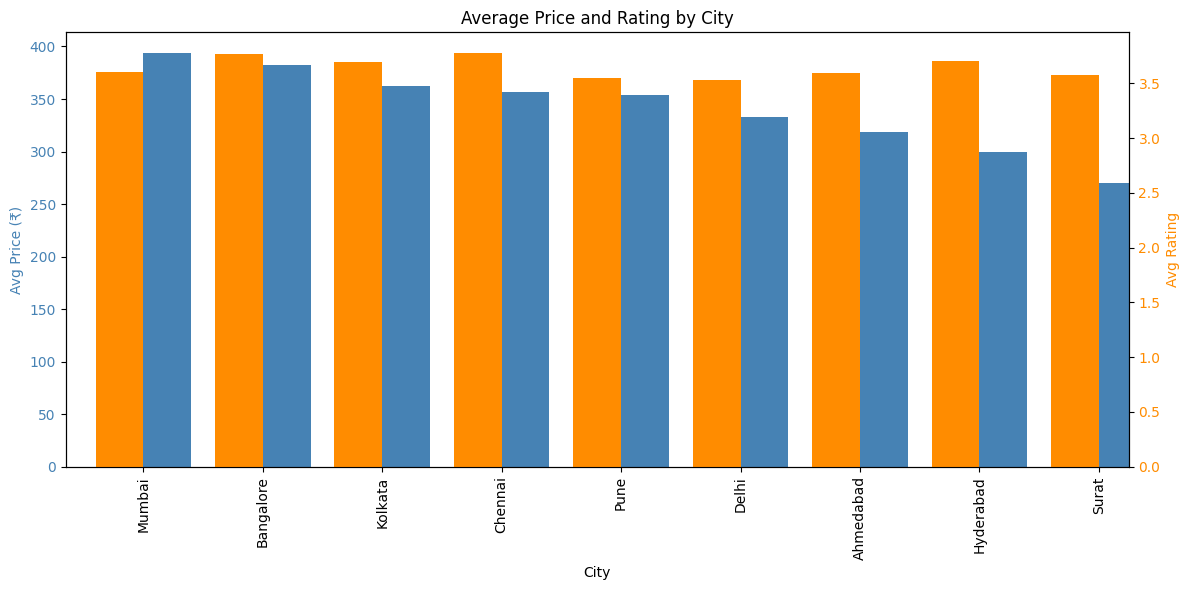

In [23]:
# Grouped Analysis: Average Price and Rating by City

grouped = df.groupby('City')[['Price', 'Avg ratings']].mean().dropna().sort_values(by='Price', ascending=False)

print(grouped.head())

# Plot grouped bar chart
grouped_plot = grouped.head(10)  # top 10 cities by price

fig, ax1 = plt.subplots(figsize=(12, 6))

grouped_plot['Price'].plot(kind='bar', ax=ax1, position=0, width=0.4, color='steelblue', label='Avg Price')
ax1.set_ylabel('Avg Price (₹)', color='steelblue')
ax1.tick_params(axis='y', labelcolor='steelblue')

ax2 = ax1.twinx()
grouped_plot['Avg ratings'].plot(kind='bar', ax=ax2, position=1, width=0.4, color='darkorange', label='Avg Rating')
ax2.set_ylabel('Avg Rating', color='darkorange')
ax2.tick_params(axis='y', labelcolor='darkorange')

plt.title("Average Price and Rating by City")
ax1.set_xlabel("City")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()
